# Front Matter

Loading in libraries, mounting google drive, and more.

In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PAC Data

## Load, Clean, and Merge PAC Datasets

In [3]:
# Load in all the necessary data

dir = '/content/drive/My Drive/DS320/data/PAC Receipts.csv'
receipt_df = pd.read_csv(dir, header = 4)

dir = '/content/drive/My Drive/DS320/data/PAC Disbursements.csv'
disburse_df = pd.read_csv(dir, header = 3)

dir = '/content/drive/My Drive/DS320/data/PAC Contributions to Candidates.csv'
contribution_df = pd.read_csv(dir, header = 4)

dir = '/content/drive/My Drive/DS320/data/PAC Cash on Hand.csv'
onhand_df = pd.read_csv(dir, header = 4)

In [4]:
# Merging the four data tables into one for ease of use
receipt_df = receipt_df.copy()
receipt_df = receipt_df.merge(disburse_df, on = 'ID #', how = 'outer').rename(columns = {'Rank_x' : 'rank_receipt', 'Committee_x' : 'committee_receipt', 'Amount_x' : 'amount_receipt', 'Committee_y' : 'Committee_disbursement', 'Rank_y': 'rank_disbursement', 'Amount_y': 'amount_disbursement'})
receipt_df = receipt_df.merge(contribution_df, on = 'ID #', how = 'outer').rename(columns = {'Rank': 'rank_contribution', 'Committee' : 'committee_contribution', 'Amount' : 'amount_committee'})
df = receipt_df.merge(onhand_df, on = 'ID #', how = 'outer').rename(columns = {'Rank': 'rank_cash_on_hand', 'Committee' : 'committee_cash_on_hand', 'Amount' : 'amount_cash_on_hand'})

# Converting column name strings into lower case format
df.columns = df.columns.str.lower()

Note: the cell immediately below can only be run once. Running a second time without loading in the data below will result in an error.

In [5]:
# Establish empty list for storing all company values
committee = []

# Locate all companies from each data set category and append to committee list
for row in range(0, 50):
  committee.append(df['committee_receipt'][row])
for row in range(50, 54):
  committee.append(df['committee_disbursement'][row])
for row in range(54, 62):
  committee.append(df['committee_contribution'][row])
for row in range(62, len(df)):
  committee.append(df['committee_cash_on_hand'][row])

# Add committee to working dataframe
df.insert(0, 'committee', committee, True)

# Remove old columns that have NA values
df = df.drop(['committee_receipt', 'committee_disbursement', 'committee_contribution', 'committee_cash_on_hand'], axis=1)

In [6]:
# List of stop words / common words
replace_list = ['PAC', 'POLITICAL ACTION COMMITTEE', 'LLC', 'INC', ',', '.', 'FUND', 'FEDERAL', ')', '(', '-', '&', 'CORPORATION', 'AND', 'OF', 'SERVICES']

# Loop through company name column to remove stop words
for company in range(len(df['committee'])):
  for term in replace_list:
    df['committee'][company] = df['committee'][company].replace(term, '').strip()

Note: <br>
The following block of code is done to account for unusual encoding of company names. For example, after removing stop words, the company `KOCH INDUSTRIES` is encoded as `KOCH INDUSTRIES KOCH`. There were 14 companies with such unusual naming conventions.

In [7]:
df['committee'][9] = 'KOCH INDUSTRIES'
df['committee'][11] = 'UNITEDHEALTH GROUP'
df['committee'][12] = 'AT&T EMPLOYEE'
df['committee'][14] = 'PRICEWATERHOUSECOOPERS'
df['committee'][17] = 'ELEVANCE HEALTH'
df['committee'][20] = 'BNSF RAILWAY COMPANY RAIL'
df['committee'][26] = 'GENERAL DYNAMICS CORPORATION'
df['committee'][27] = 'AFLAC'
df['committee'][29] = 'VERIZON COMMUNICATIONS'
df['committee'][36] = 'ALTRIA GROUP'
df['committee'][52] = 'MERCK CO EMPLOYEES'
df['committee'][54] = 'BAE SYSTEMS USA'
df['committee'][62] = 'DIRECT SUPPLY PARTNERS DSI'
df['committee'][82] = 'ASURION'

In [8]:
#change columns with money strings to float
#df = df.fillna(0)
df[df.columns[3]] = df[df.columns[3]].replace('[\$,]', '', regex=True).astype(float)
df[df.columns[5]] = df[df.columns[5]].replace('[\$,]', '', regex=True).astype(float)
df[df.columns[7]] = df[df.columns[7]].replace('[\$,]', '', regex=True).astype(float)
df[df.columns[9]] = df[df.columns[9]].replace('[\$,]', '', regex=True).astype(float)

In [9]:
#df = df.fillna(0)
df.isnull().sum()

committee               0
rank_receipt           37
id #                    0
amount_receipt         37
rank_disbursement      37
amount_disbursement    37
rank_contribution      37
amount_committee       37
rank_cash_on_hand      37
amount_cash_on_hand    37
dtype: int64

## EDA of PAC Data

In [ ]:
# df.describe().apply(lambda s: s.apply(lambda x: f'{x:.3f}'))

<ipython-input-24-68ee56673834>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_amounts = df.corr()[amounts]
<ipython-input-24-68ee56673834>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_ranks = df.corr()[ranks]


[Text(0.5, 1.0, 'Amount Correlations')]

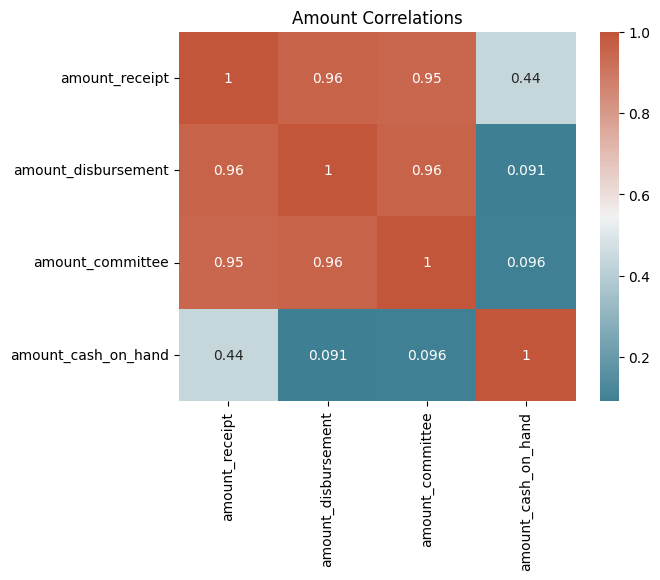

In [24]:
# Correlation matrix for amounts only!

amounts = ['amount_receipt', 'amount_disbursement', 'amount_committee', 'amount_cash_on_hand']
ranks = ['rank_receipt', 'rank_disbursement', 'rank_contribution', 'rank_cash_on_hand']

corr_amounts = df.corr()[amounts]
corr_amounts.drop(ranks, inplace = True)
corr_ranks = df.corr()[ranks]
corr_ranks.drop(amounts, inplace = True)


sns.heatmap(corr_amounts, xticklabels=corr_amounts.columns, yticklabels=corr_amounts.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True)).set(
    title="Amount Correlations")

[Text(0.5, 1.0, 'Rank Correlations')]

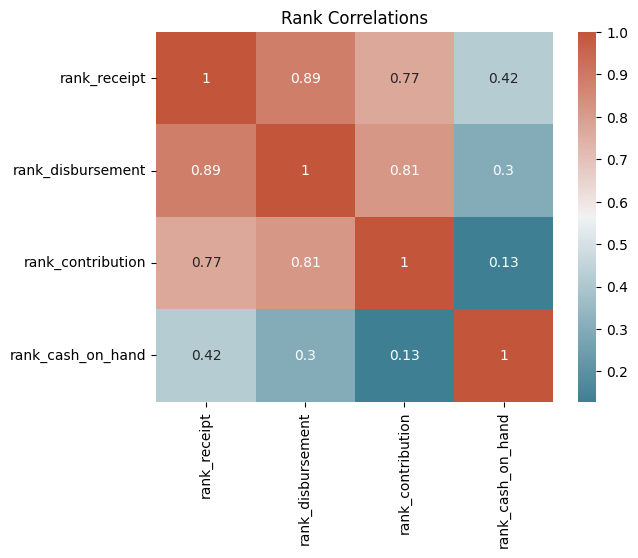

In [23]:
sns.heatmap(corr_ranks, xticklabels=corr_ranks.columns, yticklabels=corr_ranks.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True)).set(
    title="Rank Correlations")

In [25]:
# WHAT IS THIS DOING????
corr_amounts[corr_amounts < 1].unstack().transpose()\
    .sort_values( ascending=False)\
    .drop_duplicates()

amount_disbursement  amount_committee       0.958192
amount_receipt       amount_disbursement    0.957933
                     amount_committee       0.947463
                     amount_cash_on_hand    0.437806
amount_committee     amount_cash_on_hand    0.096456
amount_disbursement  amount_cash_on_hand    0.091428
amount_receipt       amount_receipt              NaN
dtype: float64

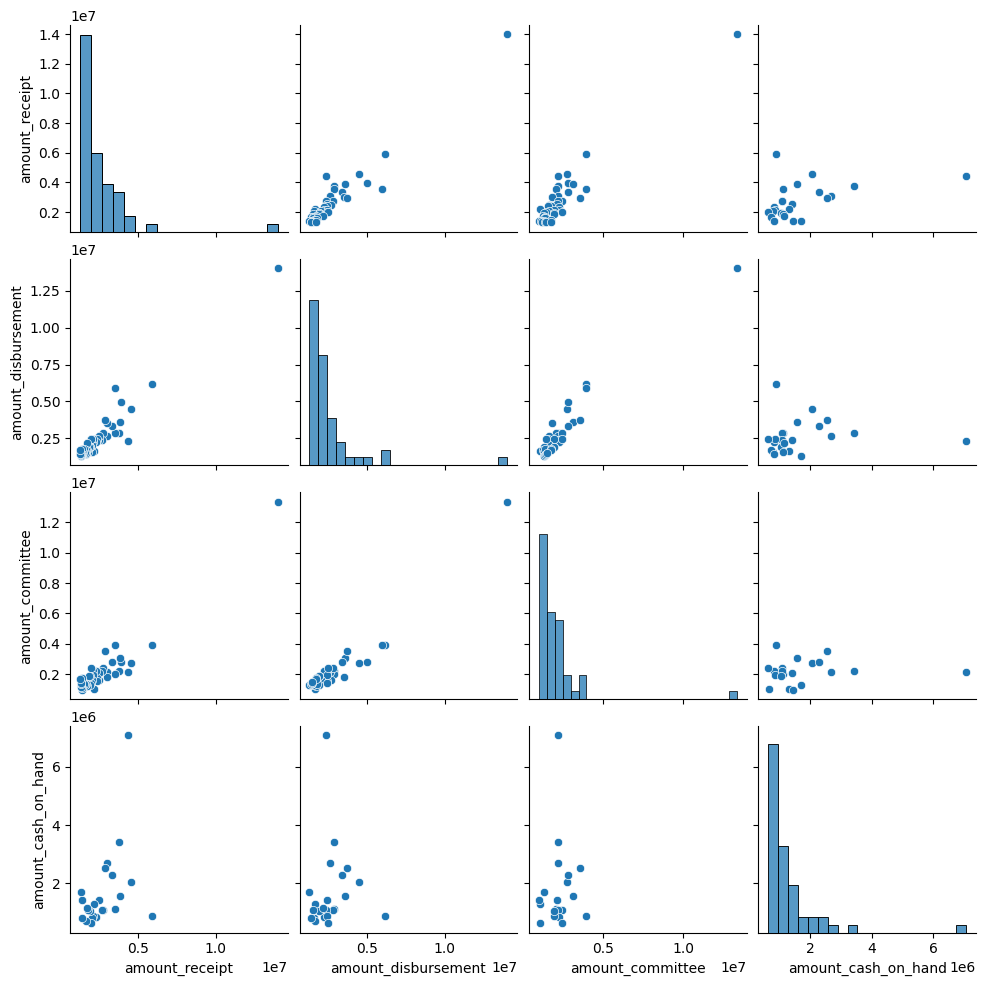

In [20]:
# Again, only of the amounts!
sns.pairplot(df[amounts])

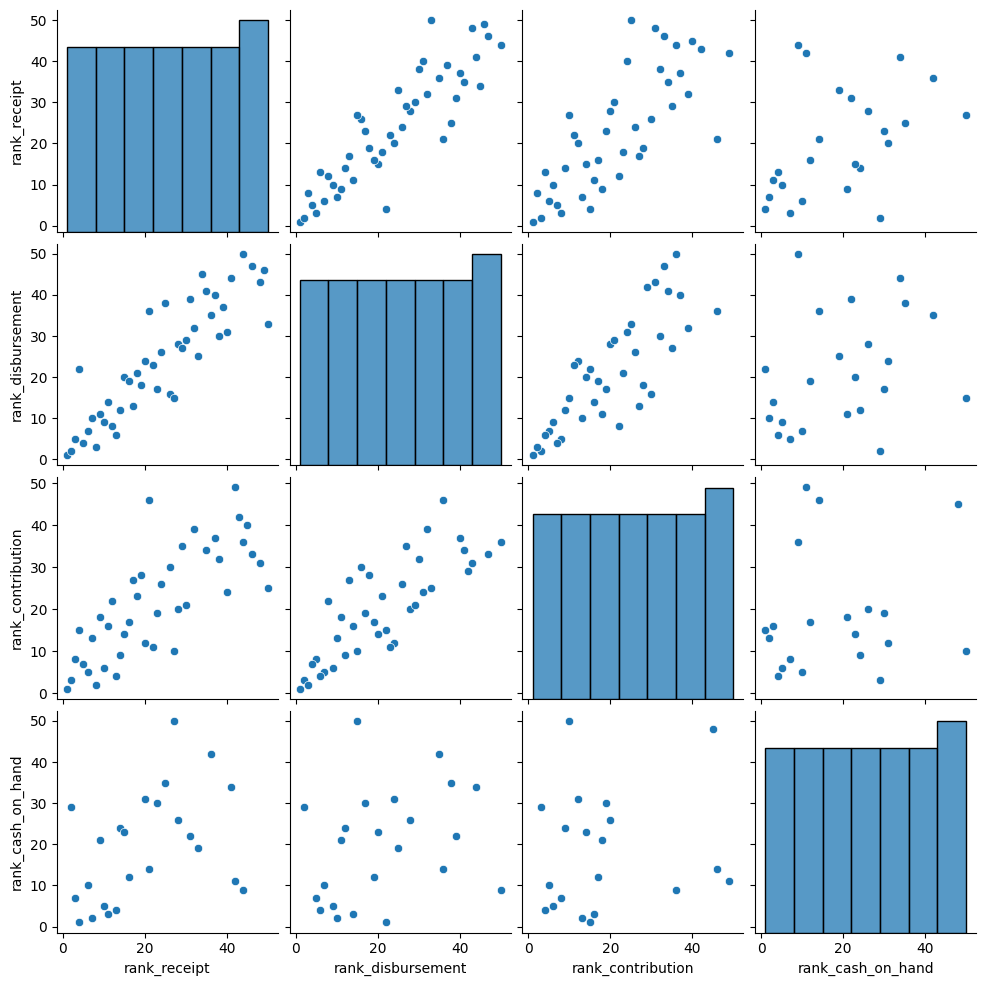

In [21]:
sns.pairplot(df[ranks])

### Visualizing Amounts Per Category


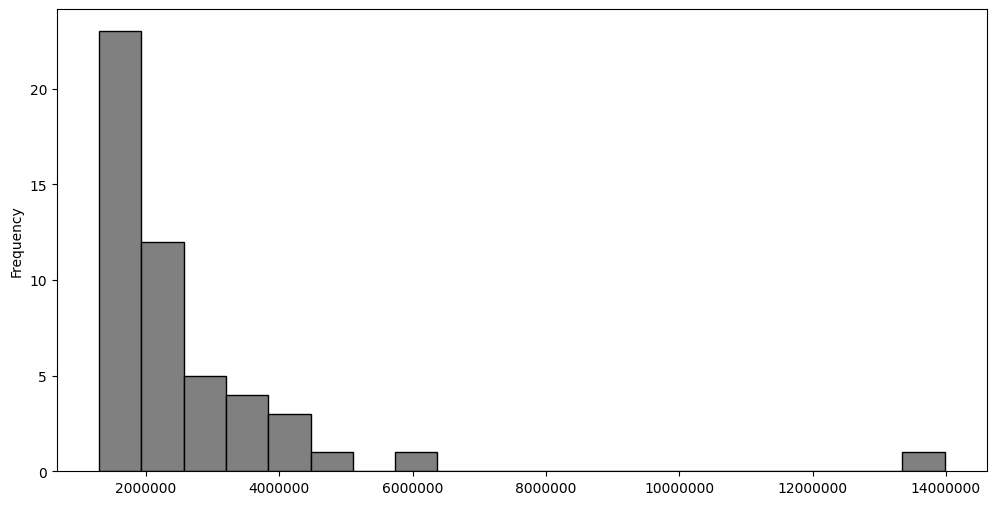

In [22]:
df['amount_receipt'].plot(kind='hist', bins=20, figsize=(12,6), facecolor='grey',edgecolor='black')
plt.ticklabel_format(style='plain')

In [ ]:
df['amount_disbursement'].plot(kind='hist', bins=20, figsize=(12,6), facecolor='grey',edgecolor='black')
plt.ticklabel_format(style='plain')

In [ ]:
df['amount_committee'].plot(kind='hist', bins=20, figsize=(12,6), facecolor='grey',edgecolor='black')
plt.ticklabel_format(style='plain')

In [ ]:
df['amount_cash_on_hand'].plot(kind='hist', bins=20, figsize=(12,6), facecolor='grey',edgecolor='black')
plt.ticklabel_format(style='plain')

# Fortune 1000 Data


## Load and Clean Fortune 1000 Dataset

In [ ]:
# Load in the data
dir = '/content/drive/My Drive/DS320/data/Fortune_1000.csv'
fortune_1000_df = pd.read_csv(dir)
# select only desired columns
fortune_1000_df = fortune_1000_df[["company","revenue","profit","sector","state"]]
# Format column names to match format of PAC data
fortune_1000_df["company"] = fortune_1000_df["company"].str.upper()

## EDA of Fortune 1000 Data

In [ ]:
fortune_1000_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   company  1000 non-null   object 
 1   revenue  1000 non-null   float64
 2   profit   997 non-null    float64
 3   sector   1000 non-null   object 
 4   state    1000 non-null   object 
dtypes: float64(2), object(3)
memory usage: 39.2+ KB


In [ ]:
fortune_1000_df.describe()

,revenue,profit
count,1000.000000,997.000000
mean,17986.801400,2026.476329
std,40813.281554,6421.578081
min,2107.200000,-6520.000000
25%,3500.750000,195.400000
50%,6375.500000,572.000000
75%,14615.475000,1498.300000
max,572754.000000,94680.000000


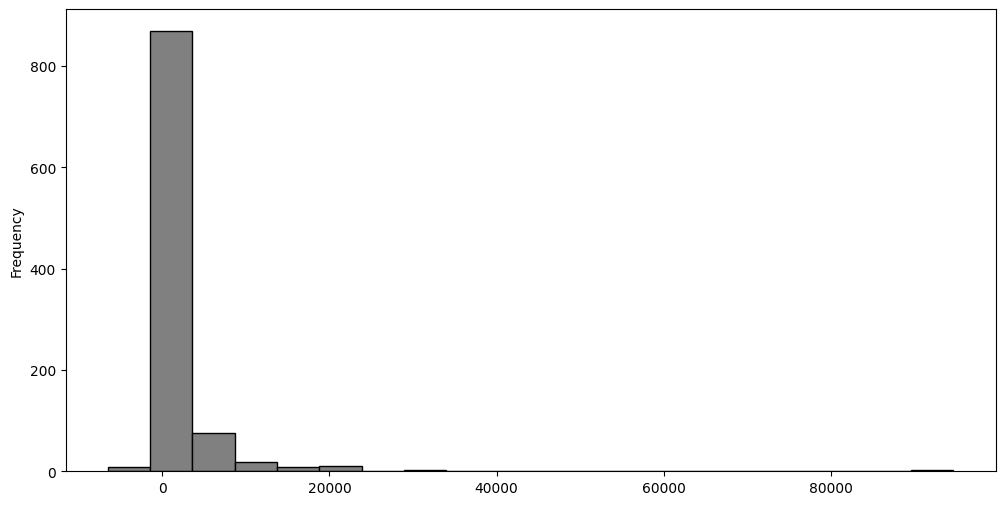

In [ ]:
fortune_1000_df['profit'].plot(kind='hist', bins=20, figsize=(12,6), facecolor='grey',edgecolor='black')
plt.ticklabel_format(style='plain')

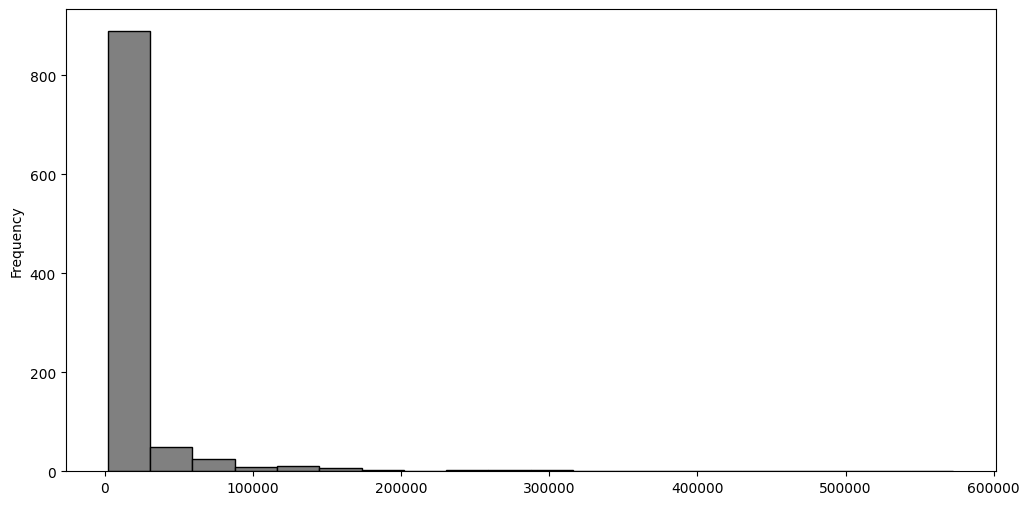

In [ ]:
fortune_1000_df['revenue'].plot(kind='hist', bins=20, figsize=(12,6), facecolor='grey',edgecolor='black')
plt.ticklabel_format(style='plain')

<Axes: xlabel='sector'>

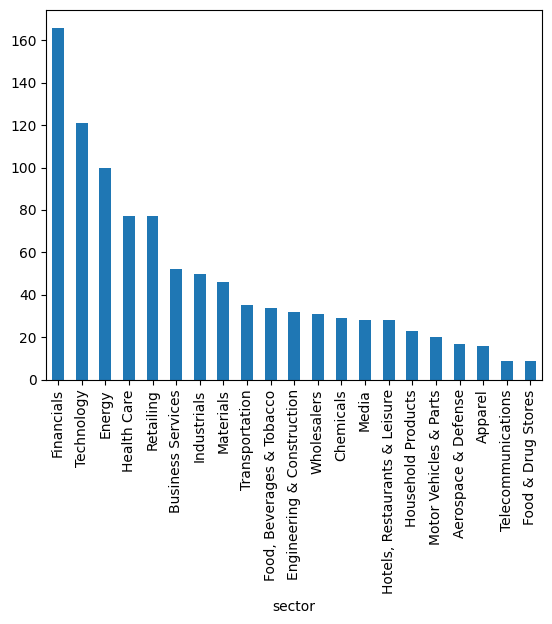

In [ ]:
fortune_1000_df.groupby('sector')['sector'].count().sort_values(ascending=False).plot.bar()
plt.title('')
plt.xlabel('count')
plt.ylabel('sector')

In [ ]:
sector_df=fortune_1000_df[['company','profit','sector', 'state']]
sectorProfit=sector_df.groupby(['sector'], as_index = False).sum('profit').sort_values(
    by=['profit'], ascending = False)

sectorProfit.rename(columns = {
    'sector':'sector',
    'state':'state',
    'profit':'sum_profit'}, inplace = True)
#top 3 sectors
sectorProfit.head(3)

,sector,sum_profit
6,Financials,556635.2
17,Technology,459503.3
9,Health Care,209442.4


In [ ]:
df_top_sector = fortune_1000_df[(fortune_1000_df['sector'] == 'Technology') |(fortune_1000_df['sector'] == 'Financials') | (fortune_1000_df['sector'] == 'Health Care')]
df_top_sector


,company,revenue,profit,sector,state
2,APPLE,365817.0,94680.0,Technology,CA
3,CVS HEALTH,292111.0,7910.0,Health Care,RI
4,UNITEDHEALTH GROUP,287597.0,17285.0,Health Care,MN
6,BERKSHIRE HATHAWAY,276094.0,89795.0,Financials,NE
7,ALPHABET,257637.0,76033.0,Technology,CA
...,...,...,...,...,...
983,PURE STORAGE,2180.8,-143.3,Technology,CA
987,DROPBOX,2157.9,335.8,Technology,CA
992,CHEMED,2139.3,268.6,Health Care,OH
997,COWEN,2112.8,295.6,Financials,NY


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.sunburst(df_top_sector, path=['sector', 'state'], values='revenue', 
                  width =800, height =800)
fig.show()

In [ ]:
state_df=pd.DataFrame(fortune_1000_df.groupby('state')['state'].count().sort_values(ascending=False))
state_df=state_df.rename(columns={'state': 'num'})

In [ ]:
import plotly.express as px

fig = px.choropleth(locations=state_df.index, locationmode="USA-states", color=state_df['num'], scope="usa")
fig.show()

#TF-IDF

In [ ]:
# Establish terms for string matching based on the larger dataset (Fortune 1000)
term_bank = []
for company in df['committee']:
  for term in company.split(' '):
    if (term not in term_bank) & (term != ''):
      term_bank.append(term)
for company in fortune_1000_df['company']:
  for term in company.split():
    if (term not in term_bank) & (term != ''):
      term_bank.append(term)

In [ ]:
# Establish a list of all possible companies
rows = []
for row in df['committee']:
  rows.append(row)
for row in fortune_1000_df['company']:
  rows.append(row)

In [ ]:
# Initialize term matrix with null values in each
term_matrix = pd.DataFrame(np.zeros((len(rows), len(term_bank))))
term_matrix.columns = term_bank

# Insert company index
term_matrix.insert(0, "companies", rows, True)

In [ ]:
for i in range(len(term_matrix['companies'])): # For all the companies in our combined dataset
  for term in term_matrix['companies'][i].split(' '): # For each word in a companies name
    if len(term) >= 1:
      term_matrix[str(term)][i] += 1

In [ ]:
idf_dict = {}
for term in term_bank:
  count = 0
  for doc in range(len(term_matrix['companies'])):
    count += term_matrix[term][doc]
    idf_dict[term] = len(rows) / count
# print(idf_dict)

<ipython-input-64-eef739478716>:6: RuntimeWarning: divide by zero encountered in double_scalars
  idf_dict[term] = len(rows) / count


Note: <br>
The following line of code will take approximately 10 minutes to run

In [ ]:
tf_idf_df = term_matrix.copy()
for i in range(len(term_matrix['companies'] )):
  for j in term_bank:
   tf_idf_df[j][i] = term_matrix[j][i] / idf_dict[j]
tf_idf_df

In [ ]:
# Converting matrix to easily manipulatable format
company_column = tf_idf_df['companies']
tf_idf_df = tf_idf_df.drop('companies', axis = 1)
vector_df = tf_idf_df.to_numpy()
vector_df

array([[0.00091996, 0.00091996, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00183993, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00091996, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00091996,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00091996]])

In [ ]:
pac_vectors = vector_df[0:87]
fortune_vectors = vector_df[87:1088]

In [ ]:
index_list = [0, 9, 14, 19, 20, 21, 24, 28, 33, 34, 42, 45, 47, 54, 60, 61, 62, 64, 67, 70, 71, 73, 74, 78, 82, 84, 85, 86]
sim_score_list = []
for i in range(len(pac_vectors)):
  max = 0
  max_index = 0
  for j in range(len(fortune_vectors)):
    sim_score = np.dot(pac_vectors[i], fortune_vectors[j]) / (sum(np.sqrt(pac_vectors[i]**2)) * np.sqrt(sum(fortune_vectors[j]**2)))
    if sim_score > max:
      max_index = 87 + j
      max = sim_score
  if i not in index_list:
    sim_score_list.append(max)
  print(company_column[i], max, company_column[max_index])

In [ ]:
df['committee'][3] = 'NORTHROP GRUMMAN'
df['committee'][4] = 'BOEING'
df['committee'][5] = 'COMCAST'
df['committee'][6] = 'LOCKHEED MARTIN'
df['committee'][7] = 'HOME DEPOT'
df['committee'][8] = 'GENERAL MOTORS'
df['committee'][10] = 'RAYTHEON TECHNOLOGIES'
df['committee'][12] = 'AT&T'
df['committee'][16] = 'CIGNA'
df['committee'][18] = 'WALMART'
df['committee'][26] = 'GENERAL DYNAMICS'
df['committee'][30] = 'ELI LILLY'
df['committee'][31] = 'ABBOTT LABORATORIES'
df['committee'][32] = 'CENTENE'
df['committee'][35] = 'MARRATHON PETROLEUM'
df['committee'][40] = 'FORD MOTOR'
df['committee'][43] = 'ALPHABET'
df['committee'][46] = 'CATERPILLAR'
df['committee'][49] = 'AMAZON'
df['committee'][51] = 'CAPITAL ONE FINANCIAL'
df['committee'][52] = 'MERCK'
df['committee'][56] = 'INTEL'
df['committee'][57] = 'DAVITA'
df['committee'][59] = 'WILLIAMS'
df['committee'][63] = 'FIRSTENERGY'
df['committee'][68] = 'DOMINION ENERGY'
df['committee'][69] = 'TRUIST FINANCIAL'
df['committee'][72] = 'BANK OF AMERICA'
df['committee'][75] = 'CONSTELLATION BRANDS'
df['committee'][77] = 'CORNING'
df['committee'][80] = 'SERVICE CORP. INTERNATIONAL'
df['committee'][81] = 'MATSON'
df['committee'][83] = 'ENTERGY'

In [ ]:
combined_df = df.merge(fortune_1000_df, left_on = 'committee', right_on = 'company').drop('company', axis = 1)
top_receipt = combined_df.sort_values('amount_receipt', ascending = False).head(10).sort_values('amount_receipt')
top_receipt

#Data Visualizations

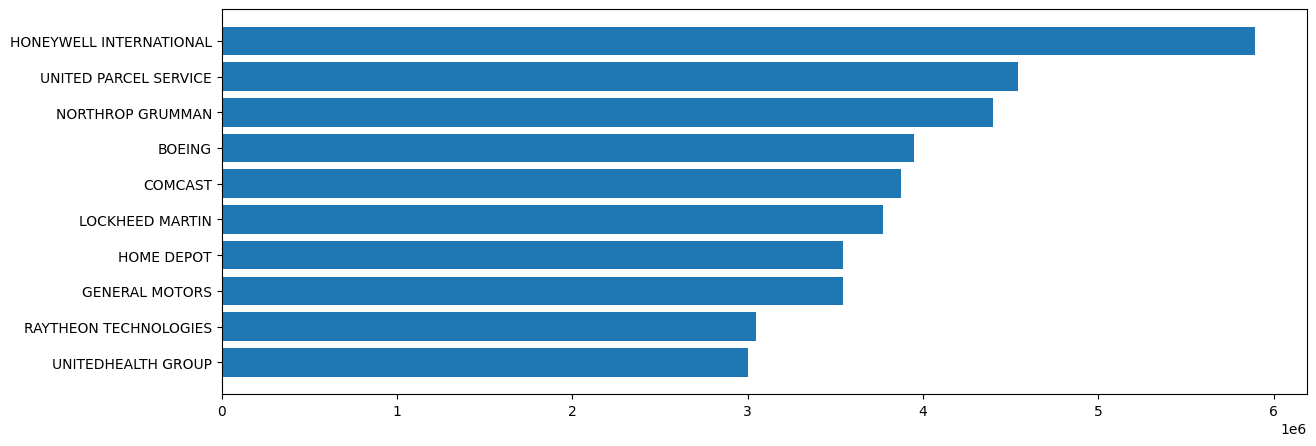

In [ ]:
fig = plt.figure(figsize = (14, 5))
plt.barh(top_receipt['committee'], top_receipt['amount_receipt'])
plt.show()

In [ ]:
sim_score_series = pd.Series(sim_score_list)
sim_score_series.describe()

count    59.000000
mean      0.658136
std       0.284399
min       0.000000
25%       0.407122
50%       0.686349
75%       0.927393
max       1.000000
dtype: float64

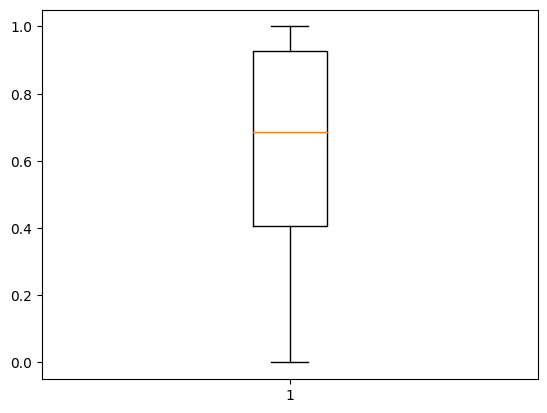

In [ ]:
plt.boxplot(sim_score_series) 
plt.show()